In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from lisflood_read_plot import *

from lisfloodreservoirs.utils.plots import plot_resops, reservoir_analysis

## Config

In [2]:
catchment = '629'
test = 'out_v5test4_deapup_newLAIIirrigMaps_RES_TL_MCT'
PATH_TESTS = Path('Z:/nahaUsers/casadje/GloFASv5/reservoirs/tests')

PATH_RESULTS = PATH_TESTS / catchment / test

PATH_OBS = Path('Z:/nahaUsers/casadje/datasets/Kazakhstan/reservoirs/timeseries/processed')

## Records

In [3]:
observed = pd.read_csv(PATH_OBS / 'shardara.csv', parse_dates=True, index_col='date')
observed.rename(columns={'inflow m3/sec': 'inflow', 'discharge m3/sec': 'outflow', 'volume million/m3': 'filling'}, inplace=True)
observed.filling /= 6700 # 5200 hm3 according to Kazakhstan

observed.head()

,inflow,outflow,filling
date,,,
2012-01-01,1342.648148,1007.0,0.565373
2012-01-02,1342.648148,1007.0,0.569701
2012-01-03,1423.666667,1007.0,0.574030
2012-01-04,1238.481481,1007.0,0.579403
2012-01-05,1527.833333,1007.0,0.582388


## Model

### Time series

In [13]:
try:
    settings_file = list(PATH_RESULTS.glob('*.xml'))[0]
except:
    settings_file = None


fill = read_tss(
    tss=PATH_RESULTS / 'resfill.tss',
    xml=settings_file
)
fill = fill.replace(1e31, np.nan).dropna(axis=1, how='all')
fill.columns = fill.columns.astype(int)

qin = read_tss(
    tss=PATH_RESULTS / 'qresin.tss',
    xml=settings_file
)
qin = qin.replace(1e31, np.nan).dropna(axis=1, how='all')
qin.columns = qin.columns.astype(int)

qout = read_tss(
    tss=PATH_RESULTS / 'qresout.tss',
    xml=settings_file
)
qout = qout.replace(1e31, np.nan).dropna(axis=1, how='all')
qout.columns= qout.columns.astype(int)

### Reservoir parameters

In [9]:
attributes = []
for txt_file in (PATH_TESTS / 'tables').glob('reservoirs*.txt'):
    # print(txt_file)
    attr = pd.read_csv(txt_file, sep='\t', header=None, index_col=0)
    attr.columns = ['_'.join(txt_file.stem.split('_')[2:])]
    attr.index.name = 'ID'
    attributes.append(attr)
attributes = pd.concat(attributes, axis=1)
attributes = attributes.loc[fill.columns]

attributes.head()

Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\tables\reservoirs_glofas5_100yr_inflow.txt
Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\tables\reservoirs_glofas5_avg_inflow.txt
Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\tables\reservoirs_glofas5_capacity.txt
Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\tables\reservoirs_glofas5_env_flow.txt


,100yr_inflow,avg_inflow,capacity,env_flow
293,360.9,51.5,1800000000,2.573
329,668.8,88.3,2000000000,4.414
472,2779.9,673.2,4160000000,33.660
525,3387.7,849.7,6700000000,42.483
610,966.8,168.5,19500000000,8.423


### Reservoir limits

In [10]:
parameters = {
    'flood_storage': 0.75,
    'flood_outflow_factor': 0.3
}

limits = pd.DataFrame(index=attributes.index, dtype=float)

limits['Vt'] = 1 # attributes.capacity
limits['Ve'] = (0.2 + 0.8 * parameters['flood_storage']) * limits.Vt
limits['Vf'] = parameters['flood_storage'] * limits.Vt
limits['Vc'] = 0.5 * limits.Vf

limits['Qf'] = parameters['flood_outflow_factor'] *  attributes['100yr_inflow']
limits['Qn'] = attributes.avg_inflow
limits['Qc'] = limits.Qn * limits.Vc / limits.Vf
limits['Qmin'] = attributes.env_flow

limits.head()

,Vt,Ve,Vf,Vc,Qf,Qn,Qc,Qmin
293,1,0.8,0.75,0.375,108.27,51.5,25.75,2.573
329,1,0.8,0.75,0.375,200.64,88.3,44.15,4.414
472,1,0.8,0.75,0.375,833.97,673.2,336.60,33.660
525,1,0.8,0.75,0.375,1016.31,849.7,424.85,42.483
610,1,0.8,0.75,0.375,290.04,168.5,84.25,8.423


### Analysis

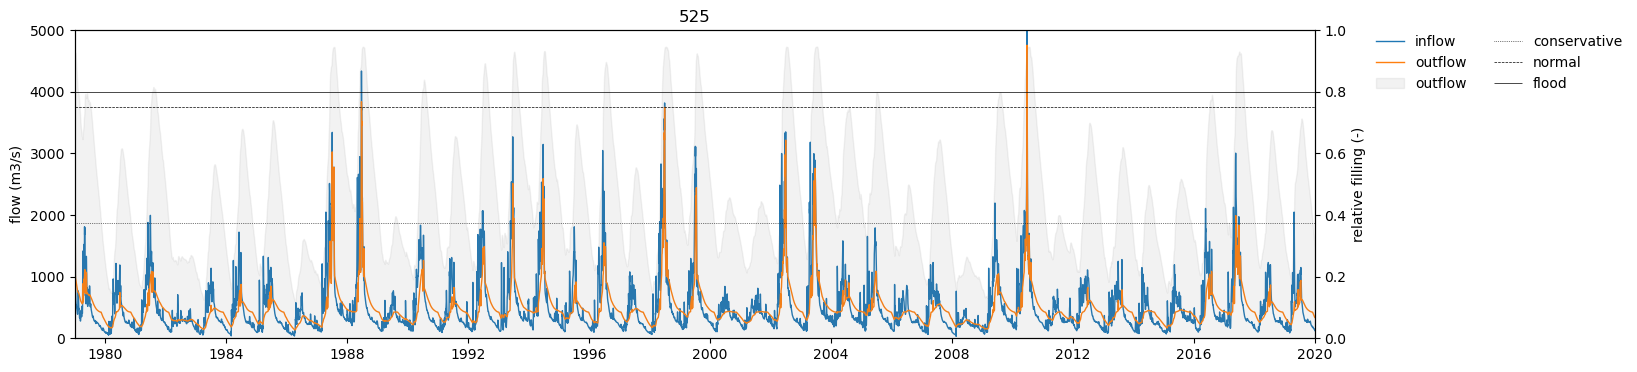

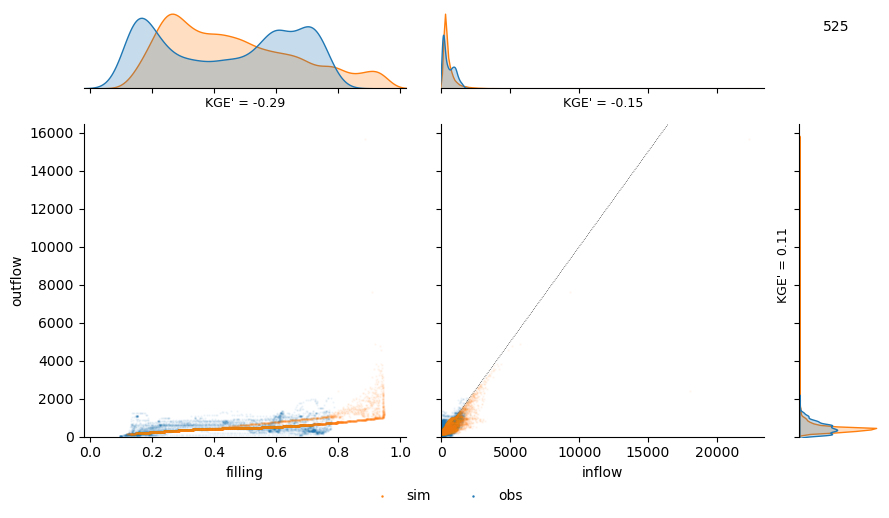

In [18]:
for ID in fill.columns:
    if ID != 525:
        continue
    sim = pd.concat((fill[ID], qin[ID], qout[ID]), axis=1)
    sim.columns = ['filling', 'inflow', 'outflow']
    plot_reservoir(sim, clim=limits.loc[ID, 'Vc'], nlim=limits.loc[ID, 'Vf'], flim=limits.loc[ID, 'Ve'], title=ID)
    if ID == 525:
        obs = observed
    else:
        obs = None
    reservoir_analysis(
        sim=sim,
        obs=obs,
        x1='filling',
        # x_thr=limits.loc[ID, ['Ve', 'Vf', 'Vf', 'Vc']],
        x2='inflow',
        y='outflow',
        # y_thr=limits.loc[ID, ['Qf', 'Qf', 'Qn', 'Qc']],
        title=ID,
    )

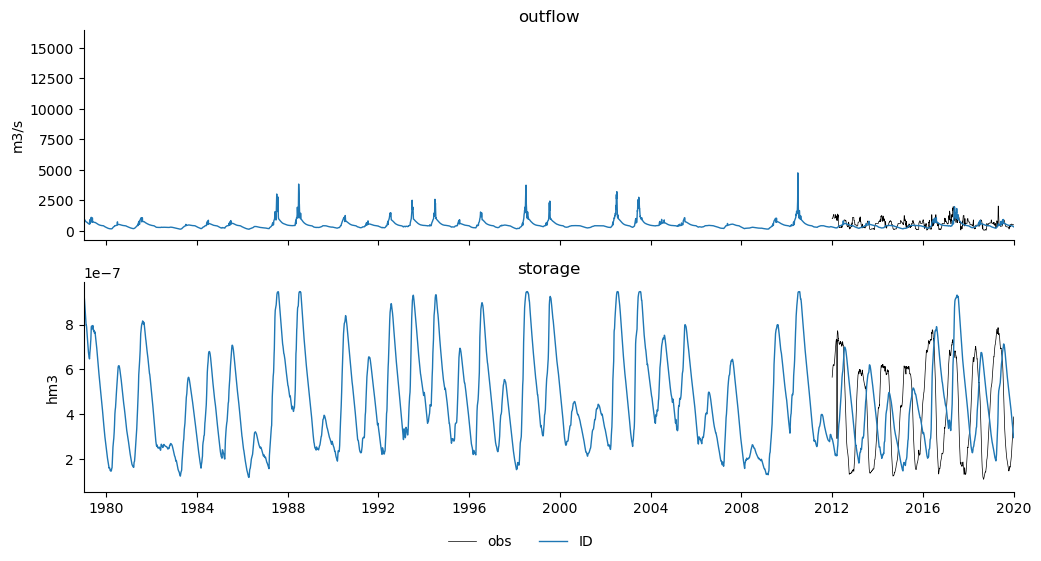

In [22]:
lineplot(
    sim={'ID': sim.rename(columns={'filling': 'storage'})},
    obs=observed.rename(columns={'filling': 'storage'})
)

In [20]:
from typing import Optional, List, Dict
def lineplot(#self,
             sim: Dict[str, pd.DataFrame],
             obs: Optional[pd.DataFrame] = None,
             Vlims: Optional[List[float]] = None,
             Qlims: Optional[List[float]] = None,
             save: Optional[Union[Path, str]] = None,
             **kwargs):
    """It plots the simulated time series of outflow and storage. If the observed time series is provided, it is plotted and the modified KGE shown.

    Parameters:
    -----------
    sim: Dict[str, pd.DataFrame]
        A dictionary that contains the name and simulated time series in a pandas.DataFrame format. This DataFrame must have at least the columns 'outflow' and 'storage'
    obs: pd.DataFrame
        The oberved time series. This DataFrame must have at least the columns 'outflow' and 'storage'
    Vlims: list (optional)
        Storage limits (if any) used in the reservoir routine
    Qlims: list (optional)
        Outflow limits (if any) used in the reservoir routine
    save: Union[Path, str]
        Directory and file where the figure will be saved

    Keyword arguments:
    ------------------
    figsize: tuple
        Size of the figure
    lw: float
        Line width
    xlim: list
        Limits of the X axis
    """

    figsize = kwargs.get('figsize', (12, 6))
    lw = kwargs.get('lw', 1)

    fig, axes = plt.subplots(nrows=2, figsize=figsize, sharex=True)

    variables = {'outflow': {'unit': 'm3/s',
                             'factor': 1,
                             'thresholds': Qlims},
                 'storage': {'unit': 'hm3',
                             'factor': 1e-6,
                             'thresholds': Vlims}}

    for ax, (var, dct) in zip(axes, variables.items()):
        f = dct['factor']
        if obs is not None:
            ax.plot(obs[var] * f, lw=.5 * lw, c='k', label='obs')
        for i, (label, serie) in enumerate(sim.items()):
            ax.plot(serie[var] * f, lw=lw, label=label)
            if obs is not None:
                try:
                    kge, alpha, beta, corr = KGEmod(obs[var], serie[var])
                except:
                    continue
                text = f'KGE={kge:.2f}  α={alpha:.2f}  β={beta:.2f}  ρ={corr:.2f}'
                if var == 'outflow':
                    y = .97 - .08 * i
                    ha = 'top'
                elif var == 'storage':
                    y = .03 + .08 * i
                    ha = 'bottom'
                ax.text(0.01, y, text, ha='left', va=ha,
                        color=f'C{i}', transform=ax.transAxes, fontsize=10,
                        bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))
        if dct['thresholds'] is not None:
            for y in dct['thresholds']:
                ax.axhline(y * f, c='gray', lw=.5, ls=':', zorder=0)
        ax.set(title=var,
               ylabel=dct['unit'],
               xlim=(serie.index.min(), serie.index.max()))
        ax.spines[['top', 'right']].set_visible(False)

    if 'xlim' in kwargs:
        ax.set_xlim(kwargs['xlim'])

    fig.legend(*ax.get_legend_handles_labels(), loc=8, ncol=1 + len(sim), frameon=False)

    if save is not None:
        plt.savefig(save, dpi=300, bbox_inches='tight')
        plt.close(fig)